In [1]:
## Standard libraries
import os
import math
import numpy as np
import pandas as pd
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("Using device", device)

Using device cpu


<Figure size 640x480 with 0 Axes>

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Seting DIR
DIR = "/content/drive/My Drive/Project CVLAB/passive"
os.makedirs(DIR, exist_ok=True)

Mounted at /content/drive


In [3]:
def scale(sample):
    return 2 * sample - 1

base_dataset = MNIST(
    root=DATASET_PATH,
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), scale]),
    download=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 367kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


In [4]:
!pip install geomloss

  Preparing metadata (setup.py) ... done
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32247 sha256=411a0db5bffbcc9af0d8926febd16928d2d9ccac332264cdc086f642baeff454
  Stored in directory: /root/.cache/pip/wheels/8c/4a/93/91d962ed04d2358b07000fb21b3164fd167b1b9cfddfce67fd
Successfully built geomloss


In [11]:
from geomloss import SamplesLoss
from math import sqrt
import random
import scipy

reg = 1
compute_ot = SamplesLoss(
                "sinkhorn",
                p=2,
                blur=sqrt(reg),
                debias=False,
                backend="tensorized"
            )

def compute_fid(X_real_feat, X_gen_feat):
    mu1 = np.mean(X_real_feat, axis=0)
    mu2 = np.mean(X_gen_feat, axis=0)
    sigma1 = np.cov(X_real_feat, rowvar=False)
    sigma2 = np.cov(X_gen_feat, rowvar=False)
    covmean = scipy.linalg.sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

In [12]:
class SimpleMNISTFeatureNet(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(96, 192, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, 1, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_feat = nn.Linear(384*5*5, latent_dim)
        self.fc_out  = nn.Linear(latent_dim, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        feat = F.relu(self.fc_feat(x))
        out = self.fc_out(feat)
        return out, feat

state_dict = torch.load(os.path.join(DIR, "EncoderNEW.pth"), map_location=device)
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}

netEncoder = SimpleMNISTFeatureNet()
netEncoder.load_state_dict(new_state_dict)
netEncoder.to(device)

SimpleMNISTFeatureNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_feat): Linear(in_features=9600, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
import torch
from torch.utils.data import Subset

def get_noisy_subset(base_dataset, std, max_digit):
    # filter indices directly (no set lookup)
    indices = [i for i, (_, label) in enumerate(base_dataset) if label <= max_digit]

    # wrapper to inject noise AFTER base_dataset transform
    def noisy_getitem(idx):
        x, y = base_dataset[idx]
        x = x + torch.randn_like(x) * std
        return x, y

    # lightweight proxy dataset
    class NoisySubset(Subset):
        def __getitem__(self, idx):
            return noisy_getitem(self.indices[idx])

    return NoisySubset(base_dataset, indices)


In [23]:
max_digits = np.arange(0, 10, 2)
stds = np.arange(0.0, 1.2, 0.2)

ot_table = pd.DataFrame(index=[f"{d}" for d in max_digits], columns=[f"{s:.1f}" for s in stds])
fid_table = pd.DataFrame(index=[f"{d}" for d in max_digits], columns=[f"{s:.1f}" for s in stds])

N = 1000  # subsample size for both reference and noisy

for d in max_digits:
    for s in stds:
        print(s,d)
        # --- subsample reference set (clean, all digits) ---
        ref_idxs = random.sample(range(len(base_dataset)), min(N, len(base_dataset)))
        ref_feats = []
        with torch.no_grad():
            for i in ref_idxs:
                X, _ = base_dataset[i]
                X = X.unsqueeze(0).to(device)
                _, f = netEncoder(X)
                ref_feats.append(f.cpu())
        ref_feats = torch.cat(ref_feats, dim=0).numpy()

        # --- subsample noisy subset (digits ≤ d, noise σ) ---
        subset = get_noisy_subset(base_dataset, std=s, max_digit=d)
        noisy_idxs = random.sample(range(len(subset)), min(N, len(subset)))
        noisy_feats = []
        with torch.no_grad():
            for i in noisy_idxs:
                X, _ = subset[i]
                X = X.unsqueeze(0).to(device)
                _, f = netEncoder(X)
                noisy_feats.append(f.cpu())
        noisy_feats = torch.cat(noisy_feats, dim=0).numpy()

        # --- compute metrics ---
        ot_val = compute_ot(torch.tensor(ref_feats), torch.tensor(noisy_feats)).item()
        fid_val = compute_fid(ref_feats, noisy_feats)

        print(ot_val, fid_val)

        ot_table.loc[f"{d}", f"{s:.1f}"] = ot_val
        fid_table.loc[f"{d}", f"{s:.1f}"] = fid_val


0.0 0


/tmp/ipython-input-2776528633.py:20: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = scipy.linalg.sqrtm(sigma1 @ sigma2)


5103.150390625 9158.763349823423
0.2 0
4910.07958984375 8754.530779662462
0.4 0
4324.6474609375 7637.362491970323
0.6000000000000001 0
3686.23876953125 6343.687556217061
0.8 0
3122.321533203125 5244.6550089249085
1.0 0
2990.52001953125 4924.5615060983855
0.0 2
2868.503173828125 4443.347173008654
0.2 2
2898.934326171875 4565.445282915851
0.4 2
2598.74609375 3999.5522938711592
0.6000000000000001 2
2399.189208984375 3734.6439958615415
0.8 2
2607.961181640625 4143.498616487731
1.0 2
2713.225341796875 4321.409171658509
0.0 4
1906.50927734375 2632.1162698510025
0.2 4
1555.90869140625 2041.1029854983876
0.4 4
1603.691162109375 2118.547398838707
0.6000000000000001 4
1699.77685546875 2361.094598996495
0.8 4
2066.73291015625 3080.721253763094
1.0 4
2188.821533203125 3304.993360735447
0.0 6
1132.2294921875 1221.5827319918426
0.2 6
1002.7325439453125 1011.7669641180867
0.4 6
1060.825439453125 1091.6381927263121
0.6000000000000001 6
1276.193603515625 1592.371438283384
0.8 6
1712.935791015625 2433.3

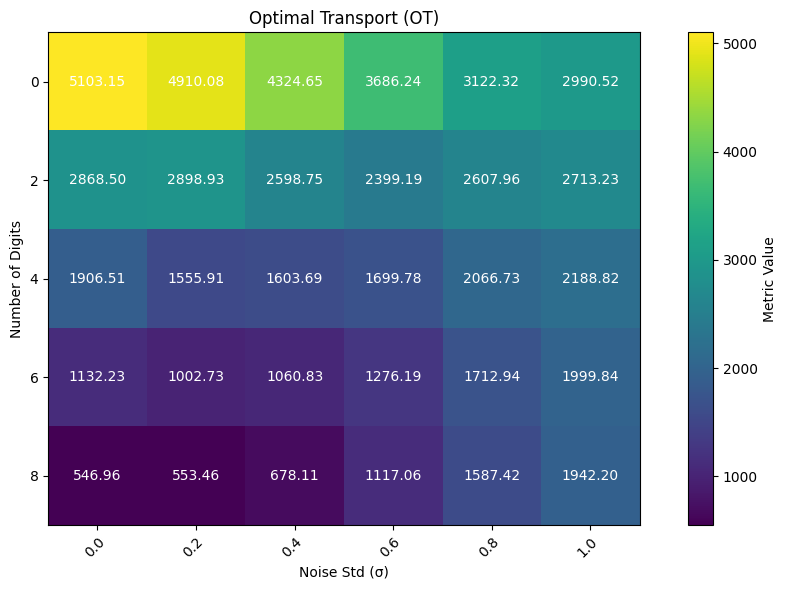

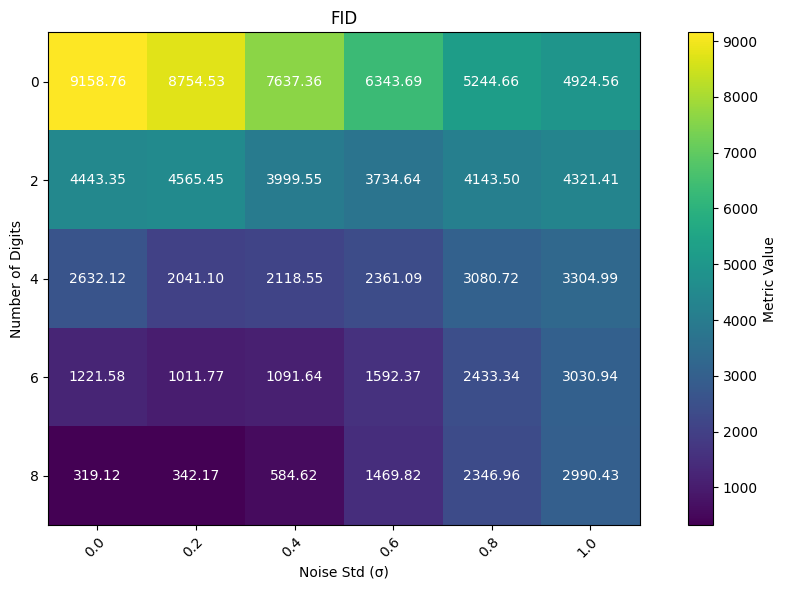

In [24]:
def plot_heatmap(table, title, cmap="viridis"):
    table = table.astype(float)
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(table.values, cmap=cmap)

    # ticks
    ax.set_xticks(np.arange(len(table.columns)))
    ax.set_yticks(np.arange(len(table.index)))
    ax.set_xticklabels(table.columns)
    ax.set_yticklabels(table.index)

    ax.set_xlabel("Noise Std (σ)")
    ax.set_ylabel("Number of Digits")
    ax.set_title(title)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # annotate each cell with the value
    for i in range(len(table.index)):
        for j in range(len(table.columns)):
            ax.text(j, i, f"{table.values[i, j]:.2f}", ha="center", va="center", color="white")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Metric Value")
    plt.tight_layout()
    plt.show()

plot_heatmap(ot_table, "Optimal Transport (OT)")
plot_heatmap(fid_table, "FID")

0.0


/tmp/ipython-input-2776528633.py:20: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = scipy.linalg.sqrtm(sigma1 @ sigma2)


α=0.00, std=0.07, OT ratio=0.0183, FID ratio=0.0043
0.1
α=0.10, std=0.06, OT ratio=0.1651, FID ratio=0.0780
0.2
α=0.20, std=0.06, OT ratio=0.3556, FID ratio=0.2754
0.30000000000000004
α=0.30, std=0.05, OT ratio=0.5346, FID ratio=0.6808
0.4
α=0.40, std=0.04, OT ratio=0.7352, FID ratio=0.7017
0.5
α=0.50, std=0.04, OT ratio=1.0068, FID ratio=1.0909
0.6000000000000001
α=0.60, std=0.03, OT ratio=1.3144, FID ratio=1.0559
0.7000000000000001
α=0.70, std=0.02, OT ratio=1.9294, FID ratio=1.8200
0.8
α=0.80, std=0.01, OT ratio=3.0082, FID ratio=3.4196
0.9
α=0.90, std=0.01, OT ratio=5.4545, FID ratio=7.7282
1.0
α=1.00, std=0.00, OT ratio=55.4422, FID ratio=6441558199.9689


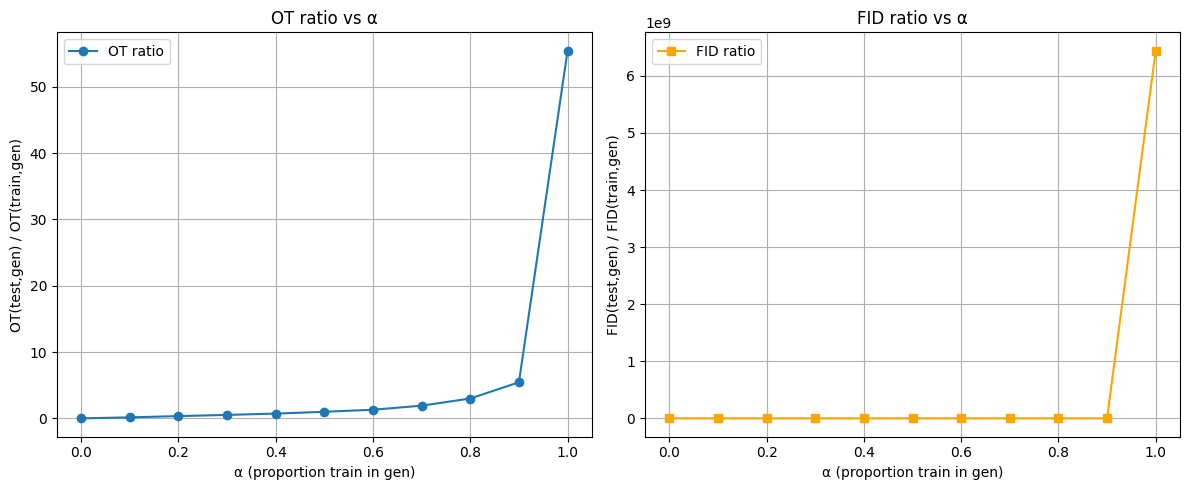

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
import random

# --- load datasets ---
def scale(x): return 2 * x - 1
transform = transforms.Compose([transforms.ToTensor(), scale])

train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
test_dataset  = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

def encode_batch(dataset, idxs, add_noise_std=None):
    Xs = []
    for idx in idxs:
        x, _ = dataset[idx]
        if add_noise_std is not None:
            x = x + add_noise_std * torch.randn_like(x)
        Xs.append(x.unsqueeze(0))
    Xs = torch.cat(Xs, dim=0).to(device)
    with torch.no_grad():
        _, feats = netEncoder(Xs)
    return feats.cpu()

steps = 11
alphas = np.linspace(0, 1, steps)
N = 1000   # subsample size per gen

ot_ratios, fid_ratios = [], []

for alpha in alphas:
    print(alpha)
    n_train = int(alpha * N)
    n_test  = N - n_train
    std = (1.0 - alpha) * 0.07

    # ---- sample fresh 1000 each iter ----
    train_idxs = random.sample(range(len(train_dataset)), 1000)
    test_idxs  = random.sample(range(len(test_dataset)),  1000)

    feats_train = encode_batch(train_dataset, train_idxs)
    feats_test  = encode_batch(test_dataset,  test_idxs)

    # subsample for gen
    idxs_train = random.sample(range(len(feats_train)), n_train) if n_train > 0 else []
    idxs_test  = random.sample(range(len(feats_test)), n_test)   if n_test > 0 else []

    subs_train = feats_train[idxs_train] if n_train > 0 else torch.empty((0, feats_train.shape[1]))
    subs_test  = feats_test[idxs_test]   if n_test  > 0 else torch.empty((0, feats_test.shape[1]))

    noisy_part = subs_test + std * torch.randn_like(subs_test) if n_test > 0 else torch.empty((0, feats_test.shape[1]))
    feats_gen  = torch.cat([subs_train, noisy_part], dim=0)

    # --- compute metrics ---
    ot_t = compute_ot(feats_gen.float(), feats_test.float()).item()
    ot_r = compute_ot(feats_gen.float(), feats_train.float()).item()
    fid_t = compute_fid(feats_gen.float().numpy(), feats_test.float().numpy())
    fid_r = compute_fid(feats_gen.float().numpy(), feats_train.float().numpy())

    ot_ratios.append(ot_t / (ot_r + 1e-8))
    fid_ratios.append(fid_t / (fid_r + 1e-8))

    print(f"α={alpha:.2f}, std={std:.2f}, OT ratio={ot_ratios[-1]:.4f}, FID ratio={fid_ratios[-1]:.4f}")

# ---- plot ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(alphas, ot_ratios, marker='o', label='OT ratio')
plt.xlabel("α (proportion train in gen)")
plt.ylabel("OT(test,gen) / OT(train,gen)")
plt.title("OT ratio vs α")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(alphas, fid_ratios, marker='s', color='orange', label='FID ratio')
plt.xlabel("α (proportion train in gen)")
plt.ylabel("FID(test,gen) / FID(train,gen)")
plt.title("FID ratio vs α")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
